<img src="https://github.com/Center-for-Health-Data-Science/PythonTsunami/blob/spring2022/figures/HeaDS_logo_large_withTitle.png?raw=1" width="300">

<img src="https://github.com/Center-for-Health-Data-Science/PythonTsunami/blob/spring2022/figures/tsunami_logo.PNG?raw=1" width="600">

# Regression models with categorical features

Let's redo the example model with one numerical and one categorical feature.

Our model has the following form:

$$ \hat{y}= b_0 + b_1 * x_1 + b_2 * x_2 + b_3 * x_3 $$

where $x_1$ is a numerical variable (number of daily cigarettes) and $x_2$, $x_3$ are indicator or dummie variables that indicate which level of exercise the person has reported, such that:

exercise 0: $x_2 = 0, x_3 = 0$

exercise 1: $x_2 = 1, x_3 = 0$

exercise 2: $x_2 = 0, x_3 = 1$

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load in data

In [2]:
link_to_file = "https://raw.githubusercontent.com/Center-for-Health-Data-Science/Python_part2/main/data/smoking_cat.csv"

df = pd.read_csv(link_to_file)
df.head()

,daily_cigarettes,life,exercise
0,7,76,0
1,11,73,0
2,27,72,1
3,23,71,0
4,13,74,0


We can have a look how often each of the exercise levels occurs:

<Axes: xlabel='exercise', ylabel='count'>

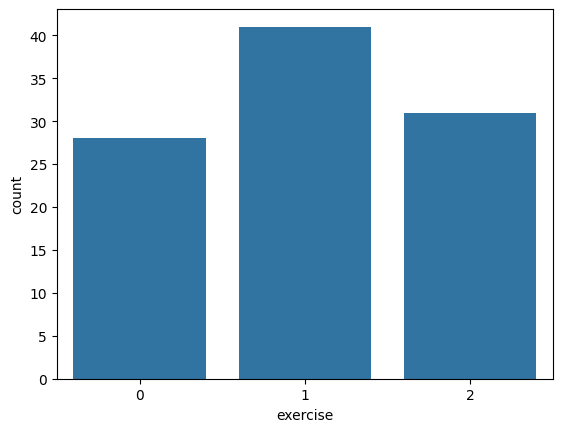

In [ ]:
sns.countplot(df, x = 'exercise')

## Dummy coding of the `exercise` column

This is the column we need to one hot encode to create x2 and x3. We will end up with two data columns instead of one and they will be binary.

In [ ]:
df['exercise'].value_counts()

exercise
1    41
2    31
0    28
Name: count, dtype: int64

We're using pandas `get_dummies` and we will drop the first level (0 exercise) since we regard it as the reference level. This means that we will not estimate a coefficient for exercise = 0.

In [ ]:
dummy_exercise = pd.get_dummies(df['exercise'], drop_first = True)
dummy_exercise.head()

,1,2
0,False,False
1,False,False
2,True,False
3,False,False
4,False,False


## Prepare the data for plugging into the model

`get_dummies` gives us a new dataframe with boolean columns. Remember, in python 1 is `True` and 0 is `False`, so this is fine.

We now want to assemble our numpy array of feature values, `X`. It will look like this:

$$ x_1\quad x_2\quad x_3 $$
$$ 7\quad 0\quad 0 $$
$$ 11\quad 0\quad 0 $$
$$ 27\quad 1\quad 0 $$
$$ ... $$

In [ ]:
#compare
df.head()

,daily_cigarettes,life,exercise
0,7,76,0
1,11,73,0
2,27,72,1
3,23,71,0
4,13,74,0


So we will need to glue together the daily ciagarettes column and the new two dummy columns. We can do this either as pandas dfs and then cast to array or cast to array and then stack them.

I'll do the first one:

In [ ]:
# drop both 'exercise' which has been dummified and 'life' which is the target value
# to create X, the np.array of predictors that we put into the model

X = pd.concat([df.drop(columns = ['exercise', 'life']),dummy_exercise], axis = 1)
X.columns = ['x1', 'x2', 'x3']
X.head()

,x1,x2,x3
0,7,False,False
1,11,False,False
2,27,True,False
3,23,False,False
4,13,False,False


In [ ]:
X = X.to_numpy()
y = df['life'].to_numpy()

Now we can split into training and testing set. I'll keep the same split from our first model so we can compare them.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25, random_state=123)

And train the linear model:

In [ ]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression()

Here is our result.

In [ ]:
lin_model.intercept_

77.35406185936127

In [ ]:
lin_model.coef_

array([-0.2726312 ,  1.08734567,  2.50152101])

It looks pretty similar to what we got when we only modelled with one numerical feature, the number of cigarettes:

$ life = 78.4 + (-0.26) * cigs $

The intercept is somewhat lower, representing the fact that this is the estimate of life expectancy at exercise level = 0 (which we assume is not good for life expectancy).

As we have expected, the two new coefficients of $x2$ and $x3$ are positive, which means that exercising at level 1 or 2 increases the life expectancy estimate compared to the base level, 0.
Specifically, exercise level 1 add 1.1 years to the life expectancy estimate and level 2 adds 2.5 years.  

## Model performance

Let's have a look at performance. We'll again predict on the held out tests set and compare our predictions `y_pred` to the true values `y_test`.

We do not need to reshape this time because `X_test`, like `X_train`, is a 2 dimensional np array.

In [ ]:
X_test.shape

(25, 3)

In [ ]:
y_pred = lin_model.predict(X_test)
y_pred

array([72.17088986, 75.4424643 , 70.81091299, 79.03768926, 70.85875317,
       75.44564344, 75.4424643 , 77.07825152, 70.85875317, 73.80985622,
       75.49348362, 69.71720903, 70.26247144, 79.31032046, 74.90038103,
       76.85663963, 79.03768926, 73.80667708, 73.80667708, 74.62457069,
       71.13138437, 70.58612197, 75.44564344, 74.40295881, 71.6288066 ])

In [ ]:
from sklearn.metrics import mean_squared_error

mse=mean_squared_error(y_test, y_pred)
mse

0.6359768234036577

Finally, we observe that our error is lower with this model than the simpler one with only one predictor (was 1.34). Great success!

## Extra: Imposing order

When working with categorical variables, you might find that pandas and you do not agree on what the first or reference level is. This can be annoying when you want to use `drop_first=True`.

In our example `exercise` has 3 levels: `0`, `1`, `2`. `0` is the first level and gets dropped which is why it did not get a column in the dummy encoded dataframe:

In [ ]:
#.head() to only see the first 10 rows
pd.get_dummies(df['exercise'], drop_first = True).head()

,1,2
0,False,False
1,False,False
2,True,False
3,False,False
4,False,False


Compare to:

In [ ]:
pd.get_dummies(df['exercise']).head()

,0,1,2
0,True,False,False
1,True,False,False
2,False,True,False
3,True,False,False
4,True,False,False


At the risk of being repetivite, `0` being the first levels means it is the level that will get dropped and therefore not have an estimated coefficient in the model.

What if we would like to make a model that has `1` the reference level (normal level of exercise) and estimates coefficients for people who exercise less (`0`) or more (`2`)? To achieve this, we must make `1` our first level in the `categories` argument:

In [ ]:
df['exercise'] = pd.Categorical(df['exercise'], categories = [1, 0, 2])

Now we get one dummy that is true if exercise = 0 and one that is true if exercise = 2:

In [ ]:
pd.get_dummies(df['exercise'], drop_first = True).head()

,0,2
0,True,False
1,True,False
2,False,False
3,True,False
4,True,False
